TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

# Importaciones necesarias

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


# Clase Moneda

In [2]:
class Moneda:
    # Diccionario de diámetros reales
    diametros_reales = {
        "1 Cent": 16.25,
        "2 Cent": 18.75,
        "5 Cent": 21.25,
        "10 Cent": 19.75,
        "20 Cent": 22.25,
        "50 Cent": 24.25,
        "1 Euro": 23.25,
        "2 Euro": 25.75
    }
    
    def __init__(self, nombre):
        self.nombre = nombre
        self.diametro_real = Moneda.diametros_reales[nombre]
        self.tamano_pixel_min = None
        self.tamano_pixel_max = None

    def __str__(self):
        return f"Moneda: {self.nombre}, Tamaño en píxeles: ({self.tamano_pixel_min:.2f}, {self.tamano_pixel_max:.2f})"
    
    @staticmethod
    def crear_lista_monedas():
        return [Moneda(nombre) for nombre in Moneda.diametros_reales]

    @staticmethod
    def mostrar_lista_monedas(lista_monedas):
        print("---------------------------------------------")
        print("{:<10} | {:>12} | {:>12}".format("NOMBRE", "TAMAÑO MIN", "TAMAÑO MAX"))
        for m in lista_monedas:
            print("{:<10} | {:12.2f} | {:12.2f}".format(m.nombre, m.tamano_pixel_min, m.tamano_pixel_max))
        print("---------------------------------------------")

    
    @staticmethod
    def calcular_tamanos(monedas, referencia_nombre, referencia_pixel):
        """Calcula el tamaño en píxeles de todas las monedas usando una moneda de referencia.
            - referencia_nombre: Nombre de la moneda de referencia
            - referencia_pixel: Tamaño en pixeles de la moneda de referencia
            - monedas: Una lista de monedas ya inicializada
        """
        # Se define un margen de error para el tamaño de las monedas
        margen = 3

        # Obtiene el diámetro real de la moneda de referencia
        diametro_referencia = Moneda.diametros_reales[referencia_nombre]
        
        # Factor de escala basado en el tamaño en píxeles proporcionado y el diámetro real
        factor = referencia_pixel / diametro_referencia

        for moneda in monedas:
            # Calcula el tamaño en píxeles para cada moneda usando el factor de escala
            tamano_pixel_estimado = moneda.diametro_real * factor
            moneda.tamano_pixel_min = tamano_pixel_estimado - margen
            moneda.tamano_pixel_max = tamano_pixel_estimado + margen
            

# Crea una lista de objetos Moneda a partir de los nombres de cada una
monedas =  Moneda.crear_lista_monedas()

# Calcula tamaños en píxeles del resto de monedas usando la moneda de 5 centimos con un tamaño de 75 píxeles como referencia
Moneda.calcular_tamanos(monedas, "5 Cent", 75)

# Muestra los resultados
Moneda.mostrar_lista_monedas(monedas)


---------------------------------------------
NOMBRE     |   TAMAÑO MIN |   TAMAÑO MAX
1 Cent     |        54.35 |        60.35
2 Cent     |        63.18 |        69.18
5 Cent     |        72.00 |        78.00
10 Cent    |        66.71 |        72.71
20 Cent    |        75.53 |        81.53
50 Cent    |        82.59 |        88.59
1 Euro     |        79.06 |        85.06
2 Euro     |        87.88 |        93.88
---------------------------------------------


# Función Para Mostrar Imagenes

In [3]:
def mostrar_imagen(imagenes, titulos=None, mostrar_ejes=False, cols=2):
    """
    Muestra una o varias imágenes con títulos opcionales y la opción de mostrar o no los ejes.

    Parámetros:
        imagenes (array o lista de arrays): La imagen o lista de imágenes a mostrar.
        titulos (str o lista de str, opcional): El título o lista de títulos de las imágenes. Por defecto es None.
        mostrar_ejes (bool, opcional): Si es True, muestra los ejes. Por defecto es False.
        cols (int, opcional): Número de columnas en el subplot. Por defecto es 2.
    """
    # Convertir imagen y titulo a listas si no lo son
    if not isinstance(imagenes, list):
        imagenes = [imagenes]
    if titulos is not None and not isinstance(titulos, list):
        titulos = [titulos]

    # Calcular el número de filas y columnas necesarias para el subplot
    n = len(imagenes)
    rows = n // cols + n % cols
    position = range(1, n + 1)

    # Crear los subplots
    for k, img, ttl in zip(position, imagenes, titulos):
        ax = plt.subplot(rows, cols, k)
        plt.imshow(img)
        plt.title(ttl)
        if not mostrar_ejes:
            plt.axis('off')

    plt.show()

# Uso de la función
# mostrar_imagen(imagen, "Titulo de la Imagen")
# o
# mostrar_imagen([imagen1, imagen2, imagen3], ["Titulo1", "Titulo2", "Titulo3"])


## Procesamiento de Imagen y conteo de Monedas

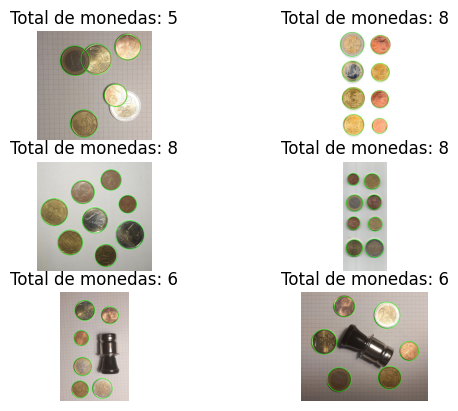

In [4]:
def detectar_y_mostrar_monedas(ruta_imagen):
    global imagen, gris, pimg, circulos_detectados

    # Cargamos la imagen de monedas de euro
    imagen = cv2.imread(ruta_imagen)                  

    # Convertimos la imagen a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Suavizamos la imagen para reducir el ruido
    pimg = cv2.medianBlur(gris, 7)

    # Localizamos círculos en la imagen  
    circulos_detectados = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=100, # Valor del gradiente
        param2=50, # Umbral acumulador
        minRadius=37,  # radio mínimo
        maxRadius=170,  # radio máximo
    )

    # Comprobamos si se han encontrado circulos en la imagen
    assert circulos_detectados is not None, "No se encontraron círculos en la imagen"
    
    # Redondea los elementos de 'circulos_detectados' al entero más cercano y los convierte a enteros sin signo de 16 bits
    circulos_detectados = np.uint16(np.around(circulos_detectados))

    # Recorremos los circulos detectados, contamos monedas y dibujamos bvordes sobre la imagen
    total_monedas = 0
    for i in circulos_detectados[0, :]:
        total_monedas += 1    
        centro = (i[0], i[1])
        radio = i[2]
        # Dibujamos el círculo en la imagen original
        cv2.circle(imagen, centro, radio, (0, 255, 0), 2)


    return imagen, total_monedas


# Llamamos varias veces a la función para detectar monedas con distintas imagenes
im1, t1 = detectar_y_mostrar_monedas("Monedas_Solapadas.jpg")
im2, t2 = detectar_y_mostrar_monedas("Monedas.jpg")
im3, t3 = detectar_y_mostrar_monedas("Monedas2.jpg")
im4, t4 = detectar_y_mostrar_monedas("Monedas4.jpg")
im6, t6 = detectar_y_mostrar_monedas("Monedas_mechero2.jpg")
im5, t5 = detectar_y_mostrar_monedas("Monedas_mechero.jpg")

arr_imagenes = [im1, im2, im3, im4, im5, im6]
arr_titulos = [t1,t2,t3,t4,t5, t6]

# Para ver todas las imagenes juntas1
mostrar_imagen(imagenes = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in arr_imagenes], 
               titulos= [f'Total de monedas: {t}' for t in arr_titulos])

# Para verlas de una en una (descomentar para usar)
# for i in range(len(arr_imagenes)):
#     mostrar_imagen(imagenes = cv2.cvtColor(arr_imagenes[i], cv2.COLOR_BGR2RGB),
#           titulos = f'Total de monedas: {arr_titulos[i]}')

TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?


## Definición de funciones para clasificar monedas y contabilizar dinero 

In [5]:
# Crea una lista de objetos Moneda a partir de los nombres de cada una
monedas =  Moneda.crear_lista_monedas()

def reset_contador_monedas():
    global monedas_contador
    monedas_contador = {
    "1 Cent": [0, 0.01],  # El primer valor (0) es la cantidad de monedas, el segundo (0.01) es el valor de cada moneda
    "2 Cent": [0, 0.02],
    "5 Cent": [0, 0.05],
    "10 Cent": [0, 0.10],
    "20 Cent": [0, 0.20],
    "50 Cent": [0, 0.50],
    "1 Euro": [0, 1.00],
    "2 Euro": [0, 2.00]
    }

# Función para agregar una moneda al contador
def agregar_moneda(nombre_moneda):
    monedas_contador[nombre_moneda][0] += 1

# Función para calcular el total de dinero
def calcular_total():
    total = 0
    for moneda, datos in monedas_contador.items():
        total += datos[0] * datos[1]
    return total

def clasificar_monedas(lista_monedas):
    for borde_detectado in circulos_detectados[0, :]:
        local_x, local_y, radio= borde_detectado
        diametro_target_moneda = radio*2
        print("Diamtro Real:", diametro_target_moneda, end=" |")
        for moneda in lista_monedas:    
            if moneda.tamano_pixel_min <= diametro_target_moneda <= moneda.tamano_pixel_max:
                print(" | MIN: ", moneda.tamano_pixel_min, " | MAX: ", moneda.tamano_pixel_max)
                agregar_moneda(moneda.nombre)
                print(f"Detectada moneda de {moneda.nombre} en [X: {local_x}, Y: {local_y}]\n")



## Clasificación de monedas (PROGRAMA INTERACTIVO)

In [6]:
def procesar_imagen(ruta_imagen):
    # Reseteamos el contador de dinero total en la imagen
    reset_contador_monedas()

    # Variable para almacenar el punto donde se hizo clic
    clicked_point = None

    # Función para manejar eventos de clic en la imagen
    def click_event(event, x, y, flags, params):
        nonlocal clicked_point
        if event == cv2.EVENT_LBUTTONDOWN:
            clicked_point = (x, y)
            cv2.destroyAllWindows()

    # Cargar la imagen
    imagen = cv2.imread(ruta_imagen)
    assert imagen is not None, "No se pudo cargar la imagen."
    imagen, _ = detectar_y_mostrar_monedas(ruta_imagen)

    # Mostrar la imagen y esperar a que el usuario haga clic
    cv2.imshow('image', imagen)
    cv2.setWindowTitle('image', "Haga click sobre la moneda de 1 EURO")
    cv2.setMouseCallback('image', click_event)
    cv2.waitKey(0)

    # Comprobar si el usuario ha hecho clic en algún punto
    assert clicked_point is not None, "No se hizo click en ningún punto"

    # Se utiliza la variable clicked_point para saber dónde ha hecho clic el usuario
    x, y = clicked_point
    print(f"El usuario hizo clic en: (X: {x}, Y: {y})")

    # Se determina la moneda en la que el usuario hizo clic comparando el punto de clic
    # con las coordenadas y radios de los círculos detectados.
    for borde in circulos_detectados[0, :]:
        cx, cy, radio = borde
        if (x - cx) ** 2 + (y - cy) ** 2 <= radio ** 2:
            print("El usuario hizo click en una moneda")
            Moneda.calcular_tamanos(monedas, "1 Euro", radio*2)
            break
    else:
        raise Exception("El usuario no hizo clic dentro de ninguna moneda.")

    # Mostramos los tamaños de las monedas calculados
    Moneda.mostrar_lista_monedas(monedas)

    # Finalmente clasificamos las monedas
    clasificar_monedas(monedas)

    # Y calculamos el dinero total en la imagen
    print("Dinero Total : " , calcular_total(), 
          end="\n*******************************************\n")

# Ejemplo de uso:

procesar_imagen("Monedas_Solapadas.jpg")
# procesar_imagen("Monedas.jpg")
# procesar_imagen("Monedas2.jpg")
# procesar_imagen("Monedas4.jpg")
procesar_imagen("Monedas_mechero.jpg")
procesar_imagen("Monedas_mechero2.jpg")
# im6, t6 = detectar_y_mostrar_monedas("Monedas_mechero2.jpg")
# procesar_imagen("Monedas_mechero2.jpg")


AssertionError: No se hizo click en ningún punto

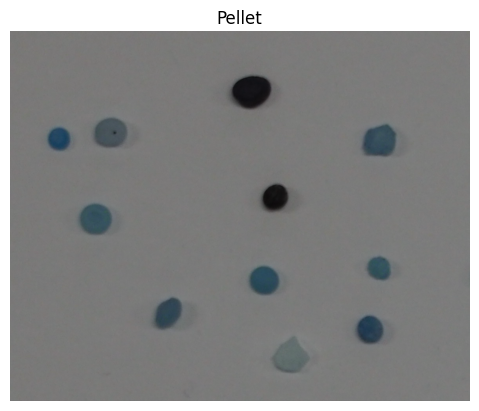

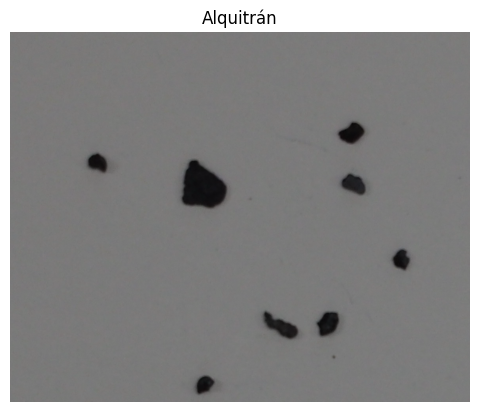

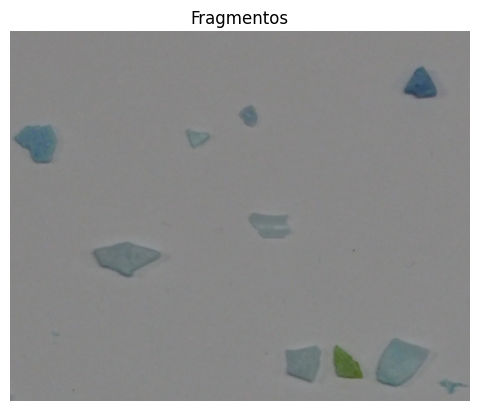

In [8]:
#Cargamos tres subimágenes de cada uno de los tres tipos considerados (el alquitrán efectivamenet no es microplástico)
imgP = cv2.imread('PEL.png') 
imgT = cv2.imread('TAR.png') 
imgF = cv2.imread('FRA.png') 

# Mostramos la imagen con los círculos
mostrar_imagen(imagen = imgP,titulo =  f'Pellet')
mostrar_imagen(imagen = imgT,titulo =  f'Alquitrán')
mostrar_imagen(imagen = imgF,titulo =  f'Fragmentos')


TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente

# Clasificación de Microplasticos

Maximas Pellets [1.07110000e+04 7.39636644e+02 5.24147099e+01 7.68296974e-01
 9.18585869e-01]
Medias Pellets [6.29436364e+03 4.64447496e+02 3.49461459e+01 6.68411746e-01
 7.64385466e-01]
Minimas Pellets [3.40550000e+03 3.27806130e+02 1.99698908e+01 6.02210433e-01
 6.50469068e-01]
Maximas Alquitran [8.66900000e+03 3.86676187e+02 2.98642472e+01 6.73581974e-01
 8.47078582e-01]
Medias Alquitran [2.40475000e+03 1.99384035e+02 1.98161505e+01 6.04530008e-01
 6.80279934e-01]
Minimas Alquitran [1.09600000e+03 1.33053822e+02 1.61526639e+01 3.84622713e-01
 3.22238953e-01]
Maximas Fragmentos [1.13600000e+04 6.09428493e+02 4.45518583e+01 7.31716580e-01
 9.80559934e-01]
Medias Fragmentos [5.86785000e+03 4.07145530e+02 3.17724590e+01 5.94300514e-01
 6.88795296e-01]
Minimas Fragmentos [1.22250000e+03 1.96409161e+02 1.91399446e+01 3.68444846e-01
 4.31686708e-01]


Text(50.722222222222214, 0.5, 'Anotada')

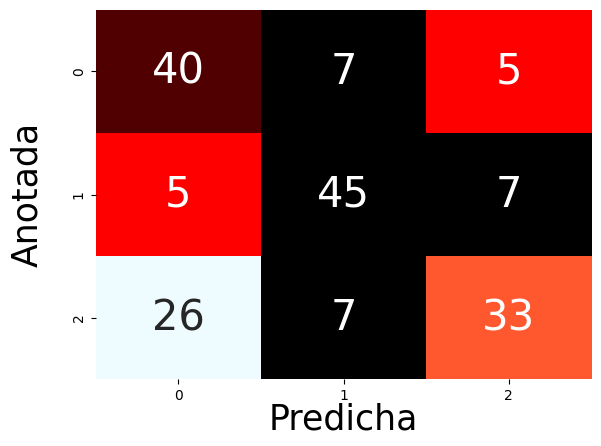

In [81]:
# ------------------- Extracción de Características -------------------- #

def obtenerCaracteristicas(contorno):

    area = cv2.contourArea(contorno)

    if area <= 250:
        return None  

    perimetro = cv2.arcLength(contorno, True)
    compacidad = (perimetro ** 2) / area 
    
    x, y, w, h = cv2.boundingRect(contorno)
    relacion_area_contenedor = area / (w * h)

    if contorno.shape[0] > 5:
        elipse = cv2.fitEllipse(contorno)
        relacion_ejes_elipse = elipse[1][0] / elipse[1][1]

    # Devolvemos los parametros
    return area, perimetro, compacidad, relacion_area_contenedor, relacion_ejes_elipse


umbral = 0
imagenes = ['TAR.png', 'FRA.png', 'PEL.png']

caracteristicas_pellets = []
caracteristicas_alquitran = []
caracteristicas_fragmentos = []
for img_path in imagenes:
    if 'TAR.png' in img_path:
        umbral = 35
    elif 'PEL.png' in img_path:
        umbral = 115
    elif 'FRA.png' in img_path:
        umbral = 130
    img = cv2.imread(img_path)
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_th1 = cv2.threshold(img_gris, umbral, 255, cv2.THRESH_BINARY_INV)
    contornos, _ = cv2.findContours(img_th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contorno in contornos:

        caracteristicas = obtenerCaracteristicas(contorno)
        if caracteristicas is not None:
            if 'TAR.png' in img_path:
                caracteristicas_alquitran.append(caracteristicas)
            elif 'FRA.png' in img_path:
                caracteristicas_fragmentos.append(caracteristicas)
            elif 'PEL.png' in img_path:
                caracteristicas_pellets.append(caracteristicas)


maxPellets = np.max(caracteristicas_pellets, axis=0)
mediasPellets = np.mean(caracteristicas_pellets, axis=0)
minPellets = np.min(caracteristicas_pellets, axis=0)
print("Maximas Pellets",maxPellets)
print("Medias Pellets",mediasPellets)
print("Minimas Pellets",minPellets)

maxAlquitran = np.max(caracteristicas_alquitran, axis=0)
mediasAlquitran = np.mean(caracteristicas_alquitran, axis=0)
minAlquitran = np.min(caracteristicas_alquitran, axis=0)
print("Maximas Alquitran",maxAlquitran)
print("Medias Alquitran",mediasAlquitran)
print("Minimas Alquitran",minAlquitran)

maxFragmentos = np.max(caracteristicas_fragmentos, axis=0)
mediasFragmentos = np.mean(caracteristicas_fragmentos, axis=0)
minFragmentos = np.min(caracteristicas_fragmentos, axis=0)
print("Maximas Fragmentos",maxFragmentos)
print("Medias Fragmentos",mediasFragmentos)
print("Minimas Fragmentos",minFragmentos)

# ------------------- Predicción de Microplásticos -------------------- #



def clasificarMicroplasticos(contorno_prediccion):
    
    caracteristicas = obtenerCaracteristicas(contorno_prediccion)

    if caracteristicas is None:
        return None

    area, _, _, relacion_area_contenedor, relacion_ejes_elipse = caracteristicas

    umbral_relacion_area_pel = mediasPellets[3]
    umbral_relacion_ejes_pel = mediasPellets[4]
    umbral_relacion_area_fra = mediasFragmentos[3]


    # Comparar con umbrales
    if area <= 450:
        return None

    if relacion_area_contenedor >= umbral_relacion_area_pel and relacion_ejes_elipse >= umbral_relacion_ejes_pel:
        return 'PEL'
    elif relacion_area_contenedor <= umbral_relacion_area_fra:
        return 'FRA'
    else:
        return 'TAR' 



imagenes_prediccion = ['fragment-03-olympus-10-01-2020.JPG', 'pellet-03-olympus-10-01-2020.JPG', 'tar-03-olympus-10-01-2020.JPG']

# Inicializar matrices de confusión
confusion_matrix = np.zeros((3, 3), dtype=int)

# Realizar predicciones en las nuevas imágenes
for img_path_prediccion in imagenes_prediccion:
    if 'tar-03-olympus-10-01-2020.JPG' in img_path_prediccion:
        umbral = 40
    elif 'pellet-03-olympus-10-01-2020.JPG' in img_path_prediccion:
        umbral = 90
    elif 'fragment-03-olympus-10-01-2020.JPG' in img_path_prediccion:
        umbral = 115
    img_prediccion = cv2.imread(img_path_prediccion)
    img_gris_prediccion = cv2.cvtColor(img_prediccion, cv2.COLOR_BGR2GRAY)
    _, img_th1_prediccion = cv2.threshold(img_gris_prediccion, umbral, 255, cv2.THRESH_BINARY_INV)
    contornos_prediccion, _ = cv2.findContours(img_th1_prediccion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Clasificar y contar las predicciones
    for contorno_prediccion in contornos_prediccion:
        
        resultado_prediccion = clasificarMicroplasticos(contorno_prediccion)
        
        if resultado_prediccion is not None:
            indice_real = -1
            indice_prediccion = -1

            if 'tar-03-olympus-10-01-2020.JPG' in img_path_prediccion:
                indice_real  = 0
            elif 'pellet-03-olympus-10-01-2020.JPG' in img_path_prediccion:
                indice_real  = 1
            elif 'fragment-03-olympus-10-01-2020.JPG' in img_path_prediccion:
                indice_real  = 2

            if resultado_prediccion == 'TAR':
                indice_prediccion = 0
            elif resultado_prediccion == 'PEL':
                indice_prediccion = 1
            elif resultado_prediccion == 'FRA':
                indice_prediccion = 2
            if indice_real  != -1 and indice_prediccion != -1:
                
                confusion_matrix[indice_real , indice_prediccion] += 1


ax = sns.heatmap(
        confusion_matrix, # confusion matrix 2D array 
        annot=True, # Muestra números en las celdas
        fmt='d', # valores enteros
        cbar=False, # sin barra de colores
        cmap='flag', # mapa de colores
        #vmax=175 # contraste de color
        annot_kws={"size": 30},  # Tamaño de la fuente para los números
    )

#Etiquetas matriz de confusión
label_font = {'size':'25'}
ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
ax.set_ylabel("Anotada", labelpad=20, fontdict=label_font)